```
uv add grad-cam
```

In [ ]:
from streamlit_image_select import image_select


In [ ]:
# 프로젝트할때 성능이 안나올때 grad_cam으로 확인해서 어디를 집중적으로 보고있는지 확인
# (배경을 집중적으로 보고 있을 수도 있음)
# 분석보고서(발표자료)에 grad_cam 으로 확인시켜주면 좋음

In [18]:
from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.models import resnet34
import os
import time
from PIL import Image

In [2]:
model = resnet34(pretrained=False)
model

c:\fastAPI_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\fastAPI_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# grad-cam 을 하기 위해서는 분류기 바로 앞 단계인 피쳐맵이 필요
# 그 중 conv_layer가 필요
# 제일 마지막 conv_layer 쓰는게 좋음 (가장 디테일한 특징)

In [6]:
model.fc = nn.Linear(512, 3, bias=True)
model.load_state_dict(torch.load("model/mymodel.pth", map_location="cpu"))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
image = Image.open("imgData/gong3.jpeg")
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_img = transforms_test(image)
input_img.shape

torch.Size([3, 224, 224])

In [10]:
# 학습 : 4차원 -> input_img : 3차원 -> unsqueeze(0)
input_img = input_img.unsqueeze(0)
input_img.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# model의 layer4의 2번째 블럭의 conv2
layer = model.layer4[2].conv2
layer1 = model.layer4[2].conv1
targets = [ClassifierOutputTarget(0)]   # ClassifierOutputTarget(*) : * 이곳엔 정답 - 공명(0)
layer

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
cam = GradCAM(model=model, target_layers=[layer, layer1])
cam.batch_size = 1
grayscale_cam = cam(input_tensor=input_img, targets=targets)    # 특징 구하기
grayscale_cam = grayscale_cam[0, :]     # 0번째 특징의 모든 행과열
grayscale_cam
# 히트맵

array([[0.14330474, 0.14330474, 0.14330474, ..., 0.19120672, 0.19120672,
        0.19120672],
       [0.14330474, 0.14330474, 0.14330474, ..., 0.19120672, 0.19120672,
        0.19120672],
       [0.14330474, 0.14330474, 0.14330474, ..., 0.19120672, 0.19120672,
        0.19120672],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(224, 224), dtype=float32)

In [ ]:
# 기여도
grayscale_cam.max()

np.float32(0.9999999)

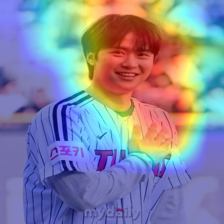

In [16]:
# grayscale : 0 - 1 사이 값 -> RGB 색상으로 변경해주면됨
image = Image.open("imgData/gong3.jpeg")
image.size      # 원본사이즈 -> (224, 224)로 해줘야 위에 만든 히트맵을 덮어 씌워서 볼 수 있음
image = image.resize((224, 224))
rgb_img = np.float32(image) / 255       # rgb 색상은 0~255이므로 위에 grayscale(0~1)과 비교하려면 255로 나눠주면됨
result_grad_cam = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True) # show_cam_on_image(원본이미지, 히트맵)
display(Image.fromarray(result_grad_cam))


In [ ]:
# 모델돌림 -> 스코어가 잘 나오든 안나오든 -> grayscale 돌려봄
# 잘 못보고있으면 grayscale을 통해 확인해서 재학습

## AblationCAM

- 피쳐맵을 하나씩 제거

In [ ]:
cam = AblationCAM(model=model, target_layers=[layer])
cam.batch_size = 1
grayscale_cam = cam(input_tensor=input_img, targets=targets)    # 특징 구하기
grayscale_cam = grayscale_cam[0, :]
grayscale_cam
# 왜 512 인가 -> 512개의 피쳐값

100%|██████████| 512/512 [00:29<00:00, 17.28it/s]


array([[0.01372974, 0.01372974, 0.01372974, ..., 0.23276561, 0.23276561,
        0.23276561],
       [0.01372974, 0.01372974, 0.01372974, ..., 0.23276561, 0.23276561,
        0.23276561],
       [0.01372974, 0.01372974, 0.01372974, ..., 0.23276561, 0.23276561,
        0.23276561],
       ...,
       [0.05235069, 0.05235069, 0.05235069, ..., 0.23510322, 0.23510322,
        0.23510322],
       [0.05235069, 0.05235069, 0.05235069, ..., 0.23510322, 0.23510322,
        0.23510322],
       [0.05235069, 0.05235069, 0.05235069, ..., 0.23510322, 0.23510322,
        0.23510322]], shape=(224, 224), dtype=float32)

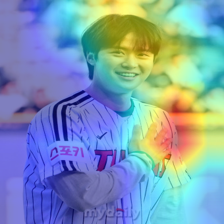

In [20]:
image = Image.open("imgData/gong3.jpeg")
image.size      # 원본사이즈 -> (224, 224)로 해줘야 위에 만든 히트맵을 덮어 씌워서 볼 수 있음
image = image.resize((224, 224))
rgb_img = np.float32(image) / 255       # rgb 색상은 0~255이므로 위에 grayscale(0~1)과 비교하려면 255로 나눠주면됨
result_grad_cam = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True) # show_cam_on_image(원본이미지, 히트맵)
display(Image.fromarray(result_grad_cam))